In [1]:
# Чтобы не вылетала ошибка Kernel Error при построении графиков в matplotlib
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset

from transformers import pipeline
from torchvision.transforms.functional import to_pil_image
import diffusers

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import DatasetFolder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torch.nn.functional as F

import sys
import pkg_resources

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

<ipython-input-2-ab9f52da2c7b>:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
NUM_INFERENCE_STEPS = 50
TIMESTEPS = 20

## 1. Prepare the validation dataset

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yangsangtai/tiny-genimage")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tiny-genimage


In [34]:
# !mv /root/.cache/kagglehub/datasets/yangsangtai/tiny-genimage/versions/1 /content/dataset_tiny_genimage

In [5]:
def collect_image_paths(root_dirs):
    """Collects image paths from the given directory list."""
    image_paths = []
    for root_dir in root_dirs:
        for subdir, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(subdir, file))
    return image_paths


class SimpleCustomBLIPDataset(Dataset):
    """Custom Dataset for loading directly from image paths, labels, and returning paths."""
    def __init__(self, image_paths, labels, blip_input, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.blip_input = blip_input

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        ### WINDOWS ADDITION!!! BURN IN HELL!!!
        # image_path = image_path.replace("\\","/")
        ### WINDOWS ADDITION!!! BURN IN HELL!!!

        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        blip_output = self.blip_input[self.blip_input['image_path'] == image_path]['blip'].item()

        return image, label, image_path, blip_output

# Define transformations

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# Paths for validation data
ai_paths_val = [
    # "/kaggle/input/tiny-genimage/imagenet_ai_0419_biggan/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_ai_0419_vqdm/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_ai_0424_sdv5/val/ai",
    # "/kaggle/input/tiny-genimage/imagenet_ai_0424_wukong/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_ai_0508_adm/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_glide/val/ai",
    "/kaggle/input/tiny-genimage/imagenet_midjourney/val/ai"
]

nature_paths_val = [
    # "/kaggle/input/tiny-genimage/imagenet_ai_0419_biggan/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_ai_0419_vqdm/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_ai_0424_sdv5/val/nature",
    # "/kaggle/input/tiny-genimage/imagenet_ai_0424_wukong/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_ai_0508_adm/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_glide/val/nature",
    "/kaggle/input/tiny-genimage/imagenet_midjourney/val/nature"
]

# Collect image paths
ai_image_paths_val = collect_image_paths(ai_paths_val)
nature_image_paths_val = collect_image_paths(nature_paths_val)

# Labels for the images (0 for AI, 1 for nature)
ai_labels_val = [0] * len(ai_image_paths_val)
nature_labels_val = [1] * len(nature_image_paths_val)

# Combine image paths and labels
val_image_paths = ai_image_paths_val + nature_image_paths_val
val_labels = ai_labels_val + nature_labels_val

In [8]:
df_blip_val = pd.read_csv('/kaggle/input/blip-annotation/blip_val_full.csv')
# df_blip_val["image_path"]= df_blip_val.apply(lambda x: x['image_path'].replace('/kaggle/input/tiny-genimage','./dataset_tiny_genimage'), axis=1)

In [9]:
df_blip_val.head(5)

,image_path,blip
0,/kaggle/input/tiny-genimage/imagenet_ai_0419_v...,a jellyfish in the sand
1,/kaggle/input/tiny-genimage/imagenet_ai_0419_v...,a group of men in graduation gowns standing in...
2,/kaggle/input/tiny-genimage/imagenet_ai_0419_v...,a dog standing on a leash in a yard
3,/kaggle/input/tiny-genimage/imagenet_ai_0419_v...,a white dog with a black nose
4,/kaggle/input/tiny-genimage/imagenet_ai_0419_v...,a man in a black coat and a black tie


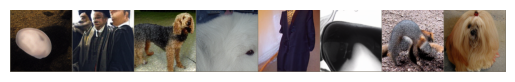

In [10]:
# Create the dataset
val_dataset = SimpleCustomBLIPDataset(val_image_paths, val_labels, blip_input=df_blip_val, transform=transform2)

# DataLoader setup
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Visualization function
def imshow(img, mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get a batch of images and labels
images, labels, image_path, blip_output = next(iter(val_loader))  # Note: Change to train_loader
out = torchvision.utils.make_grid(images)
imshow(out)

## 2. FIRE metrics

In [11]:
import torch.nn as nn
from torch import Tensor
from typing import Literal
import math
import torch, torchvision, diffusers
from typing import *
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import (
    retrieve_latents,
)


def get_resnet_model(mode: Literal["rgb", "ours"], norm_layer: Literal["batch", "instance"], pretrained: bool) -> nn.Module:

    if norm_layer == "batch":
        norm = nn.BatchNorm2d
    elif norm_layer == "instance":
        norm = nn.InstanceNorm2d
    else:
        raise AssertionError("Unknown norm layer")

    if norm == nn.InstanceNorm2d:
        model = torchvision.models.resnet50(num_classes=1000, pretrained=False, norm_layer=norm)
        model.load_state_dict(torchvision.models.ResNet50_Weights.IMAGENET1K_V2.get_state_dict(progress=True, check_hash=True), strict=False)
    else:
        model = torchvision.models.resnet50(num_classes=1000, weights="IMAGENET1K_V2", norm_layer=norm)

    if mode == "ours":
        model.conv1.weight = nn.Parameter(torch.cat([model.conv1.weight * 0.25] * 4, dim=1))
        model.conv1.in_channels = 12

    model.fc = nn.Linear(2048, 1)
    torch.nn.init.normal_(model.fc.weight.data, 0.0, 0.02)

    return model

def get_frq_resnet_model(mode: Literal["rgb", "ours", "frq"], norm_layer: Literal["batch", "instance"], pretrained: bool) -> nn.Module:

    if norm_layer == "batch":
        norm = nn.BatchNorm2d
    elif norm_layer == "instance":
        norm = nn.InstanceNorm2d
    else:
        raise AssertionError("Unknown norm layer")

    if norm == nn.InstanceNorm2d:
        model = torchvision.models.resnet50(num_classes=1000, pretrained=False, norm_layer=norm)
        model.load_state_dict(torchvision.models.ResNet50_Weights.IMAGENET1K_V2.get_state_dict(progress=True, check_hash=True), strict=False)
    else:
        model = torchvision.models.resnet50(num_classes=1000, weights="IMAGENET1K_V2", norm_layer=norm)

    if mode == "frq":
        model.conv1.weight = nn.Parameter(torch.cat([model.conv1.weight * 0.25] * 2, dim=1))
        model.conv1.in_channels = 6

    model.fc = nn.Linear(2048, 1)
    torch.nn.init.normal_(model.fc.weight.data, 0.0, 0.02)

    return model

class ESPCN(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            channels: int,
            upscale_factor: int,
    ) -> None:
        super(ESPCN, self).__init__()
        hidden_channels = channels // 2
        out_channels = int(out_channels * (upscale_factor ** 2))
        self.bn = nn.BatchNorm2d(in_channels)
        # Feature mapping
        self.feature_maps = nn.Sequential(
            nn.Conv2d(in_channels, channels, (5, 5), (1, 1), (2, 2)),
            nn.Tanh(),
            nn.Conv2d(channels, hidden_channels, (3, 3), (1, 1), (1, 1)),
            nn.Tanh(),
        )

        # Sub-pixel convolution layer
        self.sub_pixel_0 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(upscale_factor),
            nn.Sigmoid(),
        )

        self.sub_pixel_1 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(upscale_factor),
            nn.Sigmoid(),
        )

        # Initial model weights
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                if module.in_channels == 32:
                    nn.init.normal_(module.weight.data,
                                    0.0,
                                    0.001)
                    nn.init.zeros_(module.bias.data)
                else:
                    nn.init.normal_(module.weight.data,
                                    0.0,
                                    math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                    nn.init.zeros_(module.bias.data)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.bn(x)
        x = self.feature_maps(x)
        x_h = self.sub_pixel_0(x)
        x_l = self.sub_pixel_1(x)

        return x_h, x_l

def create_vae():
    # create SD pipeline as usual
    pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
                                                             torch_dtype=torch.float16, safety_checker=None)
    vae = pipe.vae
    del pipe
    torch.cuda.empty_cache()

    return vae

class FIRE_model(nn.Module):
    def __init__(self, mode="frq", norm_layer="instance", pretrained=True, radiuslow=40, radiushigh=120):
        super(FIRE_model, self).__init__()
        # initialize VAE in the DM
        self.vae = create_vae()
        self.decode_dtype = next(iter(self.vae.post_quant_conv.parameters())).dtype

        for param in self.vae.parameters():
            param.requires_grad = False

        # backend classifier
        self.resnet = get_frq_resnet_model(mode=mode, norm_layer=norm_layer, pretrained=pretrained)
        # FMRE module
        self.fft_filter_module = fft_filter(radiuslow=radiuslow, radiushigh=radiushigh, rows=256, cols=256)
        self.vae = self.vae.to("cuda")
        self.resnet = self.resnet.to("cuda")
        self.fft_filter_module = self.fft_filter_module.to("cuda")

    def calculate_reconstruction(self, initial_images):
    # from tqdm import tqdm
        decode_dtype = next(iter(self.vae.post_quant_conv.parameters())).dtype
        reconstruction = torch.zeros(initial_images.shape)
        for i in range(initial_images.shape[0]):

          latents_initial_images = retrieve_latents(self.vae.encode(initial_images[i:i+1].to(decode_dtype).to(device)))
          reconstruction = self.vae.decode(latents_initial_images.to(decode_dtype),return_dict=False)[0]

        return reconstruction

    def forward(self, x):
        middle_freq_image, middle_filtered_image, mask_mid_frq, mask_mid_filterd = self.fft_filter_module(x)

        latents_x = retrieve_latents(self.vae.encode(x.to(self.decode_dtype)))
        reconstructions_x = self.vae.decode(
                            latents_x.to(self.decode_dtype),return_dict=False
                        )[0]
        # reconstructions_x = self.calculate_reconstruction(x)

        latents_middle_filtered = retrieve_latents(self.vae.encode(middle_filtered_image.to(self.decode_dtype)))
        reconstructions_middle_filtered = self.vae.decode(
                            latents_middle_filtered.to(self.decode_dtype),return_dict=False
                        )[0]
        # reconstructions_middle_filtered = self.calculate_reconstruction(middle_filtered_image)

        # o = self.resnet(torch.cat(reconstructions_filterd))
        raw_reconstructions_delta = torch.abs(reconstructions_x - x)
        filtered_reconstructions_delta = torch.abs(reconstructions_middle_filtered - middle_filtered_image)
        o = self.resnet(torch.cat([raw_reconstructions_delta, filtered_reconstructions_delta], dim=1))

        return o, middle_freq_image, raw_reconstructions_delta, mask_mid_frq, mask_mid_filterd


class fft_filter(nn.Module):
    def __init__(self, radiuslow=35, radiushigh=120, rows=256, cols=256):
        super(fft_filter, self).__init__()
        self.radiuslow = radiuslow
        self.radiushigh = radiushigh
        self.rows = rows
        self.cols = cols
        # preset masks M_{mid} and M_{mid_c}
        i_mask, r_i_mask = self.init_mask()
        i_mask, r_i_mask = nn.Parameter(i_mask, requires_grad=False), nn.Parameter(r_i_mask, requires_grad=False)
        self.register_buffer('i_mask', i_mask)
        self.register_buffer('r_i_mask', r_i_mask)
        # # encode and decode frequency mask
        self.mask_autoencoder = ESPCN(in_channels=3, out_channels=1, channels=64, upscale_factor=1)

    def init_mask(self):
        mask = torch.ones((1, self.rows, self.cols), dtype=torch.float32, requires_grad=False)
        crow, ccol = self.rows // 2 , self.cols // 2
        center = [crow, ccol]
        x, y = torch.meshgrid(torch.arange(self.rows), torch.arange(self.cols), indexing='ij')
        mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 < self.radiuslow*self.radiuslow
        mask[:, mask_area] = 0
        mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 >= self.radiushigh*self.radiushigh
        mask[:, mask_area] = 0

        return mask, 1-mask


    # implement FMRE
    def middle_pass_filter(self, image):
        freq_image = torch.fft.fftn(image * 255, dim=(-2, -1))
        freq_image = torch.fft.fftshift(freq_image, dim=(-2, -1))
        mask_mid_frq, mask_mid_filterd = self.mask_autoencoder((20*torch.log(torch.abs(freq_image)+1e-7))/255)
        mask_mid_frq = mask_mid_frq.to(freq_image.dtype)

        middle_freq = freq_image * mask_mid_frq
        middle_freq = torch.fft.ifftshift(middle_freq, dim=(-2, -1))
        masked_image_array = torch.fft.ifftn(middle_freq, dim=(-2, -1))
        z = torch.abs(masked_image_array)
        _min = torch.min(z)
        _max = torch.max(z)
        z = (z)/(_max-_min)
        middle_freq_image = z

        mask_mid_filterd = mask_mid_filterd.to(freq_image.dtype)
        middle_filtered = freq_image * mask_mid_filterd
        middle_filtered = torch.fft.ifftshift(middle_filtered, dim=(-2, -1))
        middle_filtered_array = torch.fft.ifftn(middle_filtered, dim=(-2, -1))
        z = torch.abs(middle_filtered_array)
        _min = torch.min(z)
        _max = torch.max(z)
        z = (z)/(_max-_min)
        middle_filtered_image = z

        return middle_freq_image, middle_filtered_image, mask_mid_frq.to(torch.float32), mask_mid_filterd.to(torch.float32)


    def forward(self, image):
        middle_freq_image, middle_filtered_image, mask_mid_frq, mask_mid_filterd = self.middle_pass_filter(image)

        return middle_freq_image, middle_filtered_image, mask_mid_frq, mask_mid_filterd



In [13]:
# загрузка весов
model_fire = FIRE_model().to('cuda')
model_fire.load_state_dict(torch.load("/kaggle/input/fire_10/pytorch/default/1/fire_dm_10.weights", map_location=torch.device('cuda')))
model_fire.eval()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `No

FIRE_model(
  (vae): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlock2D(
           

In [14]:
y_true_fire = []
y_pred_fire = []
total_fire = 0
correct_fire = 0
with torch.no_grad():
    for images_fire, labels_fire, image_path, val_blip in tqdm(val_loader):
        images_fire = images_fire.to('cuda')
        labels_fire = labels_fire.to('cuda')
        outputs_fire, _, _, _, _ = model_fire(images_fire)
        predicted_fire = (outputs_fire > 0).float()

        total_fire += labels_fire.size(0)
        correct_fire += (predicted_fire.reshape(-1,) == labels_fire).sum().item()

        y_pred_fire.append(predicted_fire.cpu())
        y_true_fire.append(labels_fire.cpu())

# y_pred = np.array(y_pred)
# y_true = np.array(y_true)

y_pred_fire = torch.cat(y_pred_fire).numpy()
y_true_fire = torch.cat(y_true_fire).numpy()

  0%|          | 0/625 [00:00<?, ?it/s]<ipython-input-11-7c863c58b002>:235: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:308.)
  return middle_freq_image, middle_filtered_image, mask_mid_frq.to(torch.float32), mask_mid_filterd.to(torch.float32)
100%|██████████| 625/625 [16:26<00:00,  1.58s/it]


In [15]:
print(f"Accuracy score of FIRE model: {accuracy_score(y_true_fire, y_pred_fire):.3f}")
print(f"Precision score of FIRE model: {precision_score(y_true_fire, y_pred_fire):.3f}")
print(f"Recall score of FIRE model: {recall_score(y_true_fire, y_pred_fire):.3f}")
print(f"F1-score of FIRE model: {f1_score(y_true_fire, y_pred_fire):.3f}")


validation_accuracy_fire = 100 * correct_fire / total_fire
print(f'Validation Accuracy: {validation_accuracy_fire:.2f}%')
# Accuracy score of FIRE model: 0.756
# Precision score of FIRE model: 0.779
# Recall score of FIRE model: 0.715
# F1-score of FIRE model: 0.746

Accuracy score of FIRE model: 0.888
Precision score of FIRE model: 0.843
Recall score of FIRE model: 0.954
F1-score of FIRE model: 0.895
Validation Accuracy: 88.80%


In [16]:
from scipy import stats
# Расчёт метрик
# TP = np.sum((y_true_fire.reshape(-1,) == 1) & (y_pred_fire.reshape(-1,) == 1))
# FP = np.sum((y_true_fire.reshape(-1,) == 0) & (y_pred_fire.reshape(-1,) == 1))
# FN = np.sum((y_true_fire.reshape(-1,) == 1) & (y_pred_fire.reshape(-1,) == 0))
# TN = np.sum((y_true_fire.reshape(-1,) == 0) & (y_pred_fire.reshape(-1,) == 0))

TN, FP, FN, TP = confusion_matrix(y_true_fire.reshape(-1,), y_pred_fire.reshape(-1,)).ravel()

accuracy = (TP + TN) / len(y_true_fire)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

In [17]:
accuracy, precision, recall, f1

(0.888, 0.842756183745583, 0.954, 0.8949343339587241)

In [20]:
# Доверительный интервал для Accuracy (Wald)
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_accuracy = np.sqrt(accuracy * (1 - accuracy) / len(y_true_fire))
ci_accuracy = (accuracy - z * se_accuracy, accuracy + z * se_accuracy)
print(f"Accuracy confident interval {100*(ci_accuracy[0]):.2f}% ... {100*(ci_accuracy[1]):.2f}%")

Accuracy confident interval 87.93% ... 89.67%


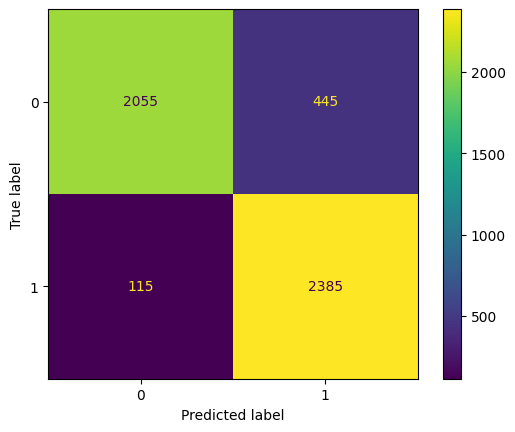

In [21]:
cm = confusion_matrix(y_true_fire.reshape(-1,), y_pred_fire.reshape(-1,), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

## 3. FIRE+BLIP metrics

In [22]:
import torch.nn as nn
from torch import Tensor
from typing import Literal
import math
import torch, torchvision, diffusers
from typing import *
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import (
    retrieve_latents,
)
from diffusers.schedulers import SchedulerMixin
from diffusers import PNDMScheduler

def get_resnet_model(mode: Literal["rgb", "ours"], norm_layer: Literal["batch", "instance"], pretrained: bool) -> nn.Module:

    if norm_layer == "batch":
        norm = nn.BatchNorm2d
    elif norm_layer == "instance":
        norm = nn.InstanceNorm2d
    else:
        raise AssertionError("Unknown norm layer")

    if norm == nn.InstanceNorm2d:
        model = torchvision.models.resnet50(num_classes=1000, pretrained=False, norm_layer=norm)
        model.load_state_dict(torchvision.models.ResNet50_Weights.IMAGENET1K_V2.get_state_dict(progress=True, check_hash=True), strict=False)
    else:
        model = torchvision.models.resnet50(num_classes=1000, weights="IMAGENET1K_V2", norm_layer=norm)

    if mode == "ours":
        model.conv1.weight = nn.Parameter(torch.cat([model.conv1.weight * 0.25] * 4, dim=1))
        model.conv1.in_channels = 12

    model.fc = nn.Linear(2048, 1)
    torch.nn.init.normal_(model.fc.weight.data, 0.0, 0.02)

    return model

def get_frq_resnet_model(mode: Literal["rgb", "ours", "frq"], norm_layer: Literal["batch", "instance"], pretrained: bool) -> nn.Module:

    if norm_layer == "batch":
        norm = nn.BatchNorm2d
    elif norm_layer == "instance":
        norm = nn.InstanceNorm2d
    else:
        raise AssertionError("Unknown norm layer")

    if norm == nn.InstanceNorm2d:
        model = torchvision.models.resnet50(num_classes=1000, pretrained=False, norm_layer=norm)
        model.load_state_dict(torchvision.models.ResNet50_Weights.IMAGENET1K_V2.get_state_dict(progress=True, check_hash=True), strict=False)
    else:
        model = torchvision.models.resnet50(num_classes=1000, weights="IMAGENET1K_V2", norm_layer=norm)

    if mode == "frq":
        model.conv1.weight = nn.Parameter(torch.cat([model.conv1.weight * 0.25] * 2, dim=1))
        model.conv1.in_channels = 6

    model.fc = nn.Linear(2048, 1)
    torch.nn.init.normal_(model.fc.weight.data, 0.0, 0.02)

    return model

class ESPCN(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            channels: int,
            upscale_factor: int,
    ) -> None:
        super(ESPCN, self).__init__()
        hidden_channels = channels // 2
        out_channels = int(out_channels * (upscale_factor ** 2))
        self.bn = nn.BatchNorm2d(in_channels)
        # Feature mapping
        self.feature_maps = nn.Sequential(
            nn.Conv2d(in_channels, channels, (5, 5), (1, 1), (2, 2)),
            nn.Tanh(),
            nn.Conv2d(channels, hidden_channels, (3, 3), (1, 1), (1, 1)),
            nn.Tanh(),
        )

        # Sub-pixel convolution layer
        self.sub_pixel_0 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(upscale_factor),
            nn.Sigmoid(),
        )

        self.sub_pixel_1 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(upscale_factor),
            nn.Sigmoid(),
        )

        # Initial model weights
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                if module.in_channels == 32:
                    nn.init.normal_(module.weight.data,
                                    0.0,
                                    0.001)
                    nn.init.zeros_(module.bias.data)
                else:
                    nn.init.normal_(module.weight.data,
                                    0.0,
                                    math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                    nn.init.zeros_(module.bias.data)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.bn(x)
        x = self.feature_maps(x)
        x_h = self.sub_pixel_0(x)
        x_l = self.sub_pixel_1(x)

        return x_h, x_l

# def create_vae():
#     # create SD pipeline as usual
#     pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
#                                                              torch_dtype=torch.float16, safety_checker=None)
#     vae = pipe.vae
#     del pipe
#     torch.cuda.empty_cache()

#     return vae


def create_pipeline():
    # create SD pipeline as usual
    pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
                                                             torch_dtype=torch.float16, safety_checker=None)
    vae = pipe.vae
    text_encoder = pipe.text_encoder
    tokenizer = pipe.tokenizer
    unet = pipe.unet

    scheduler_config = pipe.scheduler.config
    scheduler1 = pipe.scheduler
    scheduler2 = PNDMScheduler.from_config(scheduler_config)

    del pipe

    torch.cuda.empty_cache()

    return vae, text_encoder, tokenizer, unet, scheduler1, scheduler2

class FIRE_BLIP_model(nn.Module):
    def __init__(self, mode="frq", norm_layer="instance", pretrained=True, radiuslow=40, radiushigh=120):
        super(FIRE_BLIP_model, self).__init__()
        # initialize VAE in the DM
        self.vae, self.text_encoder, self.tokenizer, self.unet, self.scheduler1, self.scheduler2 = create_pipeline()
        self.decode_dtype = next(iter(self.vae.post_quant_conv.parameters())).dtype

        for param in self.vae.parameters():
            param.requires_grad = False

        for param in self.text_encoder.parameters():
            param.requires_grad = False

        for param in self.unet.parameters():
            param.requires_grad = False


        # backend classifier
        self.resnet = get_frq_resnet_model(mode=mode, norm_layer=norm_layer, pretrained=pretrained)
        # FMRE module
        self.fft_filter_module = fft_filter(radiuslow=radiuslow, radiushigh=radiushigh, rows=IMAGE_SIZE, cols=256)
        self.vae = self.vae.to("cuda")

        self.text_encoder = self.text_encoder.to("cuda")
        self.unet = self.unet.to("cuda")
        self.scheduler1.set_timesteps(num_inference_steps=NUM_INFERENCE_STEPS)
        self.scheduler2.set_timesteps(num_inference_steps=NUM_INFERENCE_STEPS)

        self.resnet = self.resnet.to("cuda")
        self.fft_filter_module = self.fft_filter_module.to("cuda")

    def calculate_reconstruction(self, initial_images):
    # from tqdm import tqdm
        decode_dtype = next(iter(self.vae.post_quant_conv.parameters())).dtype
        reconstruction = torch.zeros(initial_images.shape)
        for i in range(initial_images.shape[0]):

          latents_initial_images = retrieve_latents(self.vae.encode(initial_images[i:i+1].to(decode_dtype).to(device)))
          reconstruction = self.vae.decode(latents_initial_images.to(decode_dtype),return_dict=False)[0]

        return reconstruction

    def forward(self, x, blip_label):
        middle_freq_image, middle_filtered_image, mask_mid_frq, mask_mid_filterd = self.fft_filter_module(x)

        latents_x = retrieve_latents(self.vae.encode(x.to(self.decode_dtype)))

        ### text emb part start
        text_input = self.tokenizer(blip_label, padding="max_length", truncation=True, max_length=self.tokenizer.model_max_length, return_tensors="pt").input_ids
        text_input = text_input.to("cuda").requires_grad_(False)
        text_embedding = self.text_encoder(text_input)[0].requires_grad_(False)
        
        noise = torch.randn_like(latents_x).to("cuda")
        noisy_latents_x = self.scheduler1.add_noise(latents_x, noise, timesteps=torch.tensor(TIMESTEPS))
        noise_pred = self.unet(noisy_latents_x, torch.tensor(TIMESTEPS), encoder_hidden_states=text_embedding).sample
        # latents_x_new = self.scheduler1.step(noise_pred, torch.tensor(TIMESTEPS), noisy_latents_x).prev_sample
        latents_x_new = self.scheduler1._get_prev_sample(noisy_latents_x, torch.tensor(TIMESTEPS), torch.tensor(TIMESTEPS - 10), noise_pred)
        # latents_x_new = noisy_latents_x - noise_pred
        ### text emb part end

        reconstructions_x = self.vae.decode(latents_x_new.to(self.decode_dtype),return_dict=False)[0]
        # reconstructions_x = self.vae.decode(latents_x.to(self.decode_dtype),return_dict=False)[0]
        # reconstructions_x = self.calculate_reconstruction(x)

        latents_middle_filtered = retrieve_latents(self.vae.encode(middle_filtered_image.to(self.decode_dtype)))

        ### text emb part start
        noise_filtered = torch.randn_like(latents_middle_filtered).to("cuda")
        noisy_latents_filtered = self.scheduler2.add_noise(latents_middle_filtered, noise_filtered, timesteps=torch.tensor(TIMESTEPS))
        noise_pred_filtered = self.unet(noisy_latents_filtered, torch.tensor(TIMESTEPS), encoder_hidden_states=text_embedding).sample
        # latents_middle_filtered_new = self.scheduler2.step(noise_pred_filtered, torch.tensor(TIMESTEPS), noisy_latents_filtered).prev_sample
        latents_middle_filtered_new= self.scheduler2._get_prev_sample(noisy_latents_filtered, torch.tensor(TIMESTEPS), torch.tensor(TIMESTEPS - 10), noise_pred_filtered)
        # latents_middle_filtered_new = noisy_latents_filtered - noise_pred_filtered
        ### text emb part end

        reconstructions_middle_filtered = self.vae.decode(latents_middle_filtered_new.to(self.decode_dtype),return_dict=False)[0]
        # reconstructions_middle_filtered = self.vae.decode(latents_middle_filtered.to(self.decode_dtype),return_dict=False)[0]
        # reconstructions_middle_filtered = self.calculate_reconstruction(middle_filtered_image)

        # o = self.resnet(torch.cat(reconstructions_filterd))
        raw_reconstructions_delta = torch.abs(reconstructions_x - x)
        filtered_reconstructions_delta = torch.abs(reconstructions_middle_filtered - middle_filtered_image)
        o = self.resnet(torch.cat([raw_reconstructions_delta, filtered_reconstructions_delta], dim=1))

        return o, middle_freq_image, raw_reconstructions_delta, mask_mid_frq, mask_mid_filterd


class fft_filter(nn.Module):
    def __init__(self, radiuslow=35, radiushigh=120, rows=IMAGE_SIZE, cols=IMAGE_SIZE):
        super(fft_filter, self).__init__()
        self.radiuslow = radiuslow
        self.radiushigh = radiushigh
        self.rows = rows
        self.cols = cols
        # preset masks M_{mid} and M_{mid_c}
        i_mask, r_i_mask = self.init_mask()
        i_mask, r_i_mask = nn.Parameter(i_mask, requires_grad=False), nn.Parameter(r_i_mask, requires_grad=False)
        self.register_buffer('i_mask', i_mask)
        self.register_buffer('r_i_mask', r_i_mask)
        # # encode and decode frequency mask
        self.mask_autoencoder = ESPCN(in_channels=3, out_channels=1, channels=64, upscale_factor=1)

    def init_mask(self):
        mask = torch.ones((1, self.rows, self.cols), dtype=torch.float32, requires_grad=False)
        crow, ccol = self.rows // 2 , self.cols // 2
        center = [crow, ccol]
        x, y = torch.meshgrid(torch.arange(self.rows), torch.arange(self.cols), indexing='ij')
        mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 < self.radiuslow*self.radiuslow
        mask[:, mask_area] = 0
        mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 >= self.radiushigh*self.radiushigh
        mask[:, mask_area] = 0

        return mask, 1-mask


    # implement FMRE
    def middle_pass_filter(self, image):
        freq_image = torch.fft.fftn(image * 255, dim=(-2, -1))
        freq_image = torch.fft.fftshift(freq_image, dim=(-2, -1))
        mask_mid_frq, mask_mid_filterd = self.mask_autoencoder((20*torch.log(torch.abs(freq_image)+1e-7))/255)
        mask_mid_frq = mask_mid_frq.to(freq_image.dtype)

        middle_freq = freq_image * mask_mid_frq
        middle_freq = torch.fft.ifftshift(middle_freq, dim=(-2, -1))
        masked_image_array = torch.fft.ifftn(middle_freq, dim=(-2, -1))
        z = torch.abs(masked_image_array)
        _min = torch.min(z)
        _max = torch.max(z)
        z = (z)/(_max-_min)
        middle_freq_image = z

        mask_mid_filterd = mask_mid_filterd.to(freq_image.dtype)
        middle_filtered = freq_image * mask_mid_filterd
        middle_filtered = torch.fft.ifftshift(middle_filtered, dim=(-2, -1))
        middle_filtered_array = torch.fft.ifftn(middle_filtered, dim=(-2, -1))
        z = torch.abs(middle_filtered_array)
        _min = torch.min(z)
        _max = torch.max(z)
        z = (z)/(_max-_min)
        middle_filtered_image = z

        return middle_freq_image, middle_filtered_image, mask_mid_frq.to(torch.float32), mask_mid_filterd.to(torch.float32)


    def forward(self, image):
        middle_freq_image, middle_filtered_image, mask_mid_frq, mask_mid_filterd = self.middle_pass_filter(image)

        return middle_freq_image, middle_filtered_image, mask_mid_frq, mask_mid_filterd


In [23]:
# загрузка весов
model_blip = FIRE_BLIP_model().to('cuda')
model_blip.load_state_dict(torch.load("/kaggle/input/fire_blip_10/pytorch/default/1/fire_blip_10.weights", map_location=torch.device('cuda')))
model_blip.eval()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `No

FIRE_BLIP_model(
  (vae): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlock2D(
      

In [24]:
y_true_blip = []
y_pred_blip= []
total_blip = 0
correct_blip = 0
with torch.no_grad():
    for images_blip, labels_blip, image_path, val_blip in tqdm(val_loader):
        images_blip = images_blip.to('cuda')
        labels_blip = labels_blip.to('cuda')
        outputs_blip, _, _, _, _ = model_blip(images_blip, val_blip)
        predicted_blip = (outputs_blip > 0).float()

        total_blip += labels_blip.size(0)
        correct_blip += (predicted_blip.reshape(-1,) == labels_blip).sum().item()

        y_pred_blip.append(predicted_blip.cpu())
        y_true_blip.append(labels_blip.cpu())

# y_pred = np.array(y_pred)
# y_true = np.array(y_true)

y_pred_blip = torch.cat(y_pred_blip).numpy()
y_true_blip = torch.cat(y_true_blip).numpy()

100%|██████████| 625/625 [19:40<00:00,  1.89s/it]


In [25]:
print(f"Accuracy score of FIRE+BLIP model: {accuracy_score(y_true_blip, y_pred_blip):.3f}")
print(f"Precision score of FIRE+BLIP model: {precision_score(y_true_blip, y_pred_blip):.3f}")
print(f"Recall score of FIRE+BLIP model: {recall_score(y_true_blip, y_pred_blip):.3f}")
print(f"F1-score of FIRE+BLIP model: {f1_score(y_true_blip, y_pred_blip):.3f}")


validation_accuracy_blip = 100 * correct_blip / total_blip
print(f'Validation Accuracy: {validation_accuracy_blip:.2f}%')
# Accuracy score of FIRE+BLIP model: 0.773
# Precision score of FIRE+BLIP model: 0.829
# Recall score of FIRE+BLIP model: 0.688
# F1-score of FIRE+BLIP model: 0.752

Accuracy score of FIRE+BLIP model: 0.935
Precision score of FIRE+BLIP model: 0.911
Recall score of FIRE+BLIP model: 0.964
F1-score of FIRE+BLIP model: 0.936
Validation Accuracy: 93.46%


In [26]:
from scipy import stats
# Расчёт метрик
# TP = np.sum((y_true_fire.reshape(-1,) == 1) & (y_pred_fire.reshape(-1,) == 1))
# FP = np.sum((y_true_fire.reshape(-1,) == 0) & (y_pred_fire.reshape(-1,) == 1))
# FN = np.sum((y_true_fire.reshape(-1,) == 1) & (y_pred_fire.reshape(-1,) == 0))
# TN = np.sum((y_true_fire.reshape(-1,) == 0) & (y_pred_fire.reshape(-1,) == 0))

TN, FP, FN, TP = confusion_matrix(y_true_blip.reshape(-1,), y_pred_blip.reshape(-1,)).ravel()

accuracy = (TP + TN) / len(y_true_blip)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

In [27]:
accuracy, precision, recall, f1

(0.9346, 0.9107750472589792, 0.9636, 0.9364431486880467)

In [28]:
# Доверительный интервал для Accuracy (Wald)
z = stats.norm.ppf(0.975)  # 1.96 для 95% интервала
se_accuracy = np.sqrt(accuracy * (1 - accuracy) / len(y_true_fire))
ci_accuracy = (accuracy - z * se_accuracy, accuracy + z * se_accuracy)
print(f"Accuracy confident interval {100*(ci_accuracy[0]):.2f}% ... {100*(ci_accuracy[1]):.2f}%")

Accuracy confident interval 92.77% ... 94.15%


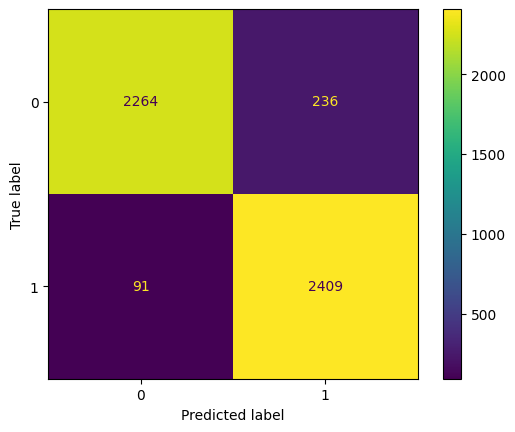

In [30]:
cm = confusion_matrix(y_true_blip.reshape(-1,), y_pred_blip.reshape(-1,), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()